In [28]:
import pickle
import numpy as np
import pandas as pd

from geopy.distance import great_circle

import pygmo as pg

import matplotlib.pyplot as plt
import seaborn as sns

import lib.pareto as pareto

In [2]:
from lib.fl_model_v10 import *

# Load Optimised Policies 

In [3]:
case = "Nepal"
output_folder = "Simulation-results"

## Load all policies proposed by dynamic uncertainty

In [4]:
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [5]:
p4_labels = global_label_tree['p4']

In [6]:
p4_pols = [global_policy_tree[label] for label in p4_labels]

In [7]:
p4_pols = np.array(p4_pols)

In [8]:
print("P4 after Multi-Period Robust Optimisation contains {} number of policies".format((p4_pols.shape)))

P4 after Multi-Period Robust Optimisation contains (1152,) number of policies


# Get Performance

## Set parameters of best estimates. Should be the same as used for 

In [11]:
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)

DPs = pd.read_csv("{}/Prepared Input Data/DPs.csv".format(case))
# DPs.columns

FLs = pd.read_csv("{}/Prepared Input Data/FLs.csv".format(case))
# FLs.columns

SPs = pd.read_csv("{}/Prepared Input Data/SPs.csv".format(case))
# SPs.columns

# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}


In [12]:
Fix_Unc

,lower,best_estimate,upper
var,,,
unit_transport_cost,7,10,15
FL_range,1,3,5
demand_per_affected,5,10,15


In [14]:
epicentre_name = "RealLocation"

In [15]:
disruptionsFLs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionFL{}.txt'.format(case,epicentre_name))
disruptionsDPs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionDP{}.txt'.format(case,epicentre_name))

In [16]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

## Evaluate DynamicUncPols under best estimates of static uncertainty

In [17]:
len(p4_pols)

1152

In [19]:
Dyn_Unc_best_est_results = []
for pol in p4_pols:
    Dyn_Unc_best_est_results.append(
        FL_model(
#             unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
#             FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **pol,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [20]:
Dyn_Unc_best_est_results = np.array(Dyn_Unc_best_est_results)

In [21]:
Dyn_Unc_best_est_results

array([[1077357.3531915338, 13, 2992.2927127713483, 53409.11799336293,
        True, None],
       [1236485.9848169028, 10, 1619.213078265886, 53409.11799336293,
        True, None],
       [406904.73883791175, 17, 6064.991807494758, 53409.11799336293,
        True, None],
       ...,
       [917693.8753822212, 18, 3857.776624917484, 45920.15739466251,
        True, None],
       [1076822.5070075898, 15, 2484.6969904120233, 45920.15739466251,
        True, None],
       [217543.85114738852, 23, 7336.270127694199, 45920.15739466251,
        True, None]], dtype=object)

In [22]:
oois = [
        'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
        'max_travel_time'
    ]
objectives_nice = [
    'Total Costs', '# Uncovered Demand Points', 'Total Uncovered Demand',
    'Max Travel Time'
]

oois = objectives_nice

In [23]:
testdf = Dyn_Unc_best_est_results

In [24]:
# plot 1 trade-off

In [29]:
# plt.scatter(testdf[:,0],testdf[:,2])

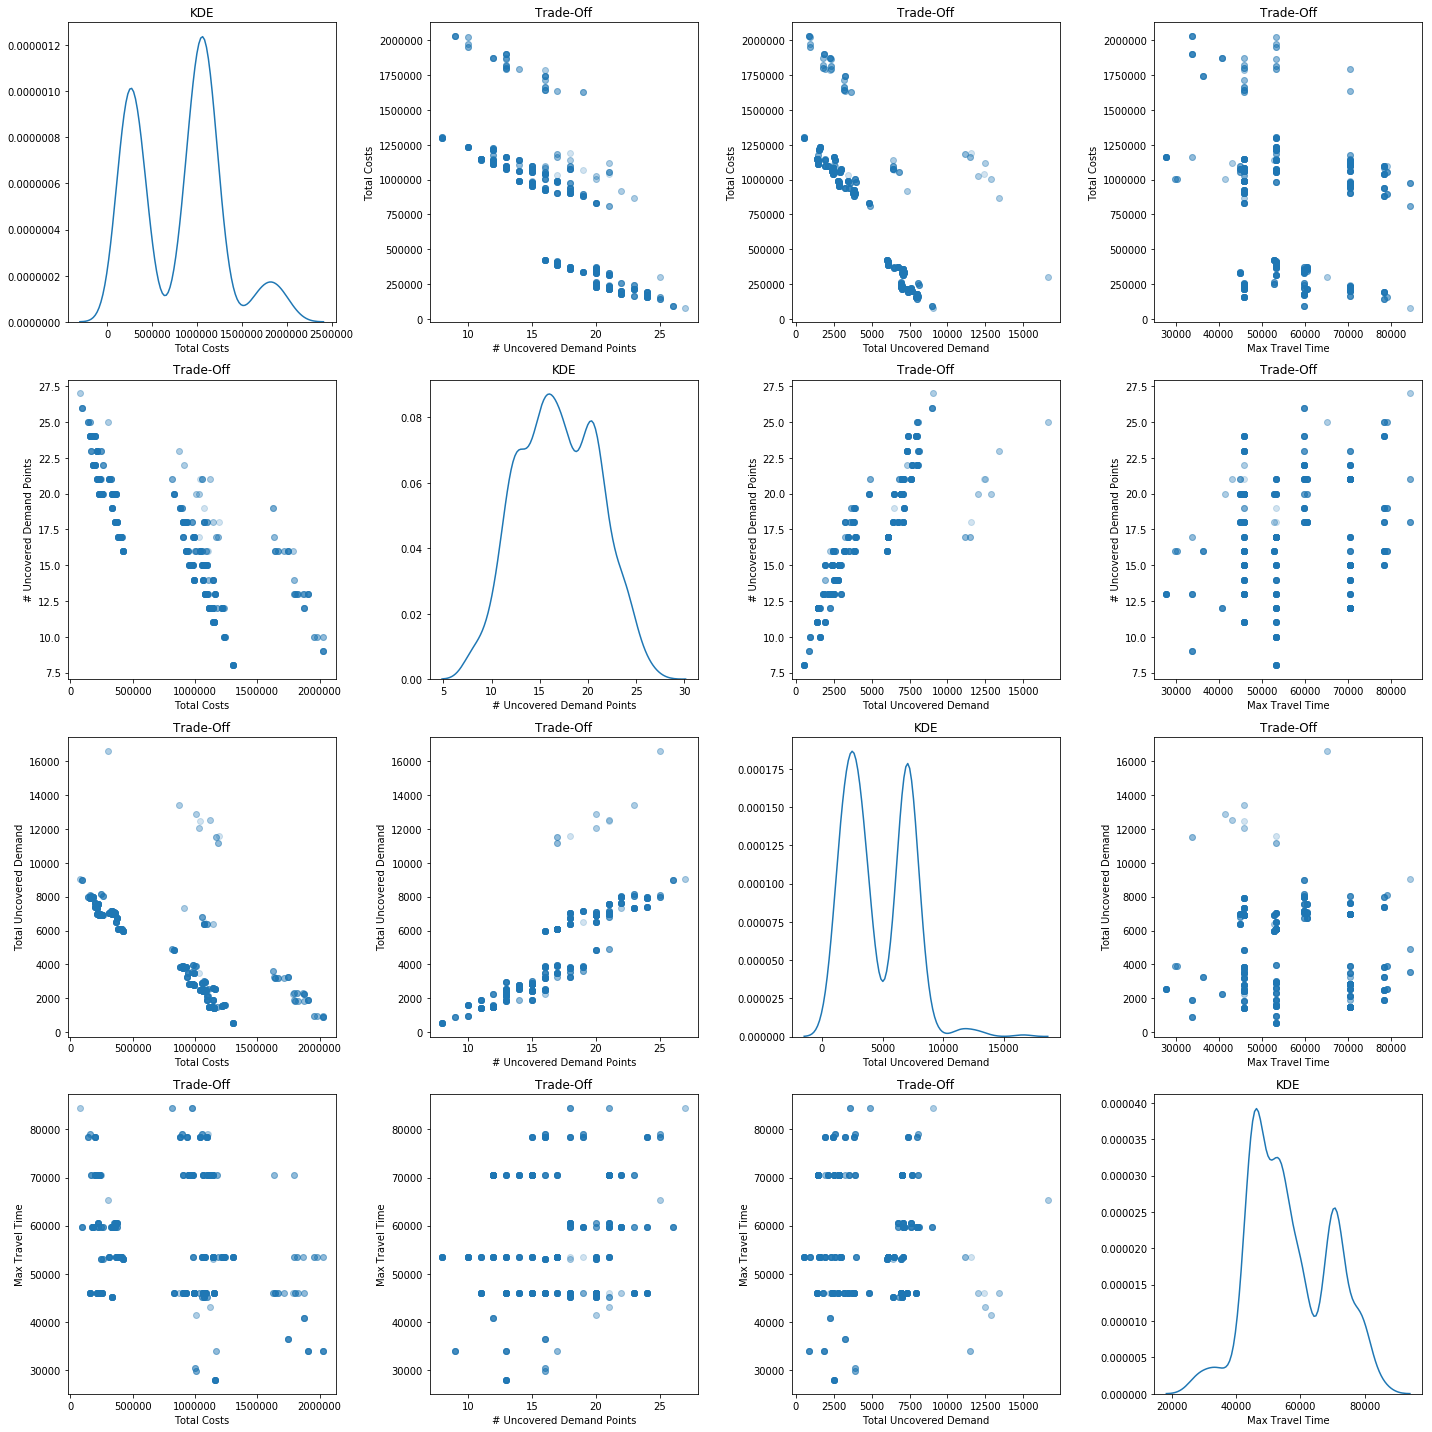

In [30]:
fig = plt.figure(figsize=(20,20))

position = 0
for i,ooi in enumerate(oois):
    for j,ooi2 in enumerate(oois):
        if i == j:
            ax = fig.add_subplot(4,4,position+1)
            sns.kdeplot(testdf[:,i], ax=ax)
            ax.set_title("KDE")
            ax.set_xlabel(oois[i])
            position+=1
            continue
        ax = fig.add_subplot(4,4,position+1)
        position +=1
        ax.scatter(testdf[:,j],testdf[:,i], alpha=0.2)
        ax.set_title("Trade-Off")
        ax.set_ylabel(oois[i])
        ax.set_xlabel(oois[j])
#         plt.show()
fig.tight_layout()
plt.show()

In [28]:
# fig = plt.figure(figsize=(20,20))

# position = 0
# for i,ooi in enumerate(oois):
#     for j,ooi2 in enumerate(oois):
#         if i == j:
# #             ax = fig.add_subplot(4,4,position+1)
# #             sns.kdeplot(testdf[:,i], ax=ax)
# #             ax.set_title("KDE")
# #             ax.set_xlabel(oois[i])
#             position+=1
#             continue
#         if j>i:
#             position+=1
#             continue
#         ax = fig.add_subplot(4,4,position+1)
#         position +=1
#         ax.scatter(testdf[:,j],testdf[:,i], alpha=0.2)
# #         ax.set_title("Trade-Off")
        
#         if j == 0:
#             ax.set_ylabel(oois[i],fontsize=20)
#         if i == 3:
#             ax.set_xlabel(oois[j], fontsize=20)
# #         plt.show()
# fig.tight_layout()
# plt.show()

## Do the same for the Pareto Front

In [31]:
test2 = pd.DataFrame(testdf[:,:4])

In [32]:
testPF = np.array(
    pareto.eps_sort(
        [list(test2.itertuples(index=True))],
        [1, 2, 3, 4], [1e-9, 1e-9, 1e-9, 1e-9]))

In [34]:
PFtest = testPF[:,1:]

In [35]:
dftmp = pd.DataFrame(PFtest)
dftmp.columns = objectives_nice

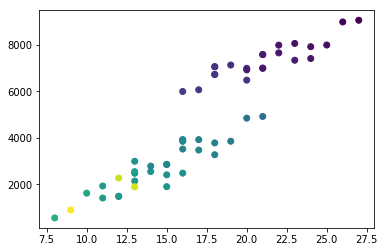

In [36]:
plt.scatter(dftmp['# Uncovered Demand Points'],dftmp['Total Uncovered Demand'],c=dftmp['Total Costs'])

C:\Users\timro\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


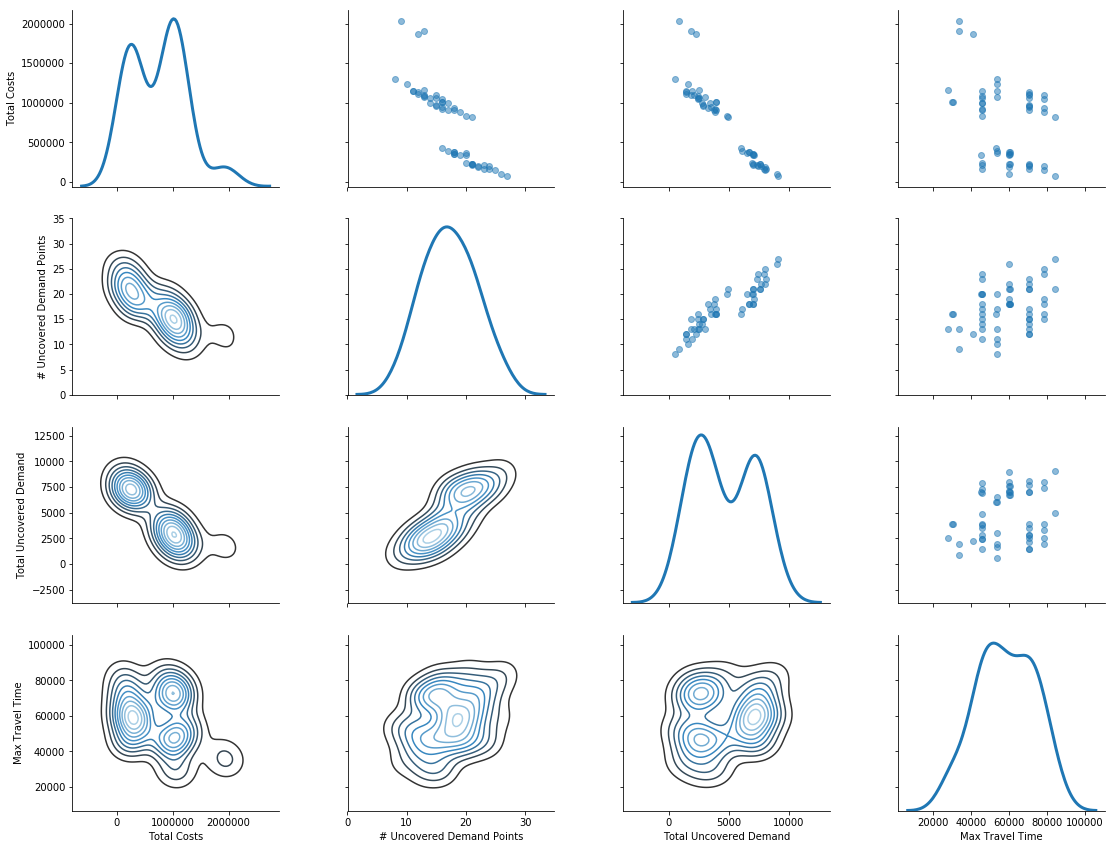

In [40]:
g = sns.PairGrid(dftmp, diag_sharey=False, size = 3, aspect=1.3)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter,  alpha=0.5)
g.map_diag(sns.kdeplot, lw=3)
# g.set_title("Pareto Front Objective Scores")
plt.tight_layout()
# plt.show()
plt.savefig("{}/Analysis/Objective-PairGrid".format(case),dpi=600)

In [41]:
plt.show()

In [44]:
# fig = plt.figure(figsize=(20,20))

# position = 0
# for i,ooi in enumerate(oois):
#     for j,ooi2 in enumerate(oois):
#         if i == j:
#             ax = fig.add_subplot(4,4,position+1)
#             sns.kdeplot(PFtest[:,i], ax=ax)
#             ax.set_title("KDE")
#             ax.set_xlabel(oois[i])
#             position+=1
#             continue
#         ax = fig.add_subplot(4,4,position+1)
#         position +=1
#         ax.scatter(PFtest[:,j],PFtest[:,i], alpha=0.5)
#         ax.set_title("Trade-Off")
#         ax.set_ylabel(oois[i])
#         ax.set_xlabel(oois[j])
# #         plt.show()
# fig.tight_layout()
# plt.savefig("{}/Analysis/Objective-Scatter".format(case),dpi=600)
# plt.show()

## Check correlation

In [45]:
from scipy.stats import pearsonr

In [46]:
#testdf[:,:4]

In [47]:
PFtest.shape

(54, 4)

In [48]:
tmpDF = pd.DataFrame(PFtest)

In [49]:
tmpDF.columns = oois

In [50]:
corr_matrix = tmpDF.corr()
corr_matrix

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
Total Costs,1.000000,-0.859099,-0.931332,-0.349829
# Uncovered Demand Points,-0.859099,1.000000,0.916108,0.361019
Total Uncovered Demand,-0.931332,0.916108,1.000000,0.223405
Max Travel Time,-0.349829,0.361019,0.223405,1.000000


In [51]:
for col1 in tmpDF.columns:
    for col2 in tmpDF.columns:
        if col1 == col2:
            corr_matrix.loc[col1,col2] = 'X'
            break
        corr, p = pearsonr(tmpDF[col1],tmpDF[col2])
        if p < 0.05:
            print (col1,col2,corr,p)
        else:
#             corr_matrix.set_value(col1,col2,0)
#             corr_matrix.set_value(col2,col1,int(0))
            corr_matrix.loc[col1,col2] = 'Not Significant'
            corr_matrix.loc[col2,col1] = 'Not Significant'

# Uncovered Demand Points Total Costs -0.8590986394108803 9.520391384443834e-17
Total Uncovered Demand Total Costs -0.9313317893443794 1.8174094814679784e-24
Total Uncovered Demand # Uncovered Demand Points 0.9161083793181053 2.741455421377274e-22
Max Travel Time Total Costs -0.3498289614671593 0.009512748015947087
Max Travel Time # Uncovered Demand Points 0.36101906181909504 0.007318983260244941


In [52]:
corr_matrix

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
Total Costs,X,-0.859099,-0.931332,-0.349829
# Uncovered Demand Points,-0.859099,X,0.916108,0.361019
Total Uncovered Demand,-0.931332,0.916108,X,Not Significant
Max Travel Time,-0.349829,0.361019,Not Significant,X


In [53]:
testdf.shape

(1152, 6)

In [65]:
tmpDF = pd.DataFrame(testdf[:,:4]).astype(float)
tmpDF.columns = oois
corr_matrix = tmpDF.corr()
corr_matrix
for col1 in tmpDF.columns:
    for col2 in tmpDF.columns:
        if col1 == col2:
            corr_matrix.loc[col1,col2] = 'X'
            break
        corr, p = pearsonr(tmpDF[col1],tmpDF[col2])
        if p < 0.05:
            print (col1,col2,corr,p)
        else:
#             corr_matrix.set_value(col1,col2,0)
#             corr_matrix.set_value(col2,col1,int(0))
            corr_matrix.loc[col1,col2] = 'Not Significant'
            corr_matrix.loc[col2,col1] = 'Not Significant'
        
corr_matrix

# Uncovered Demand Points Total Costs -0.8049569960208305 5.740243445231705e-263
Total Uncovered Demand Total Costs -0.8003222412746896 9.637981491666594e-258
Total Uncovered Demand # Uncovered Demand Points 0.8827385557597188 0.0
Max Travel Time Total Costs -0.20284695832790356 3.65927340502569e-12
Max Travel Time # Uncovered Demand Points 0.14947434327917847 3.4603308062334667e-07


,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
Total Costs,X,-0.804957,-0.800322,-0.202847
# Uncovered Demand Points,-0.804957,X,0.882739,0.149474
Total Uncovered Demand,-0.800322,0.882739,X,Not Significant
Max Travel Time,-0.202847,0.149474,Not Significant,X


In [66]:
corr_matrix

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
Total Costs,X,-0.804957,-0.800322,-0.202847
# Uncovered Demand Points,-0.804957,X,0.882739,0.149474
Total Uncovered Demand,-0.800322,0.882739,X,Not Significant
Max Travel Time,-0.202847,0.149474,Not Significant,X


In [43]:
# fig = plt.figure(figsize=(20,20))

# position = 0
# for i,ooi in enumerate(oois):
#     for j,ooi2 in enumerate(oois):
#         if i == j:
# #             ax = fig.add_subplot(4,4,position+1)
# #             sns.kdeplot(PFtest[:,i], ax=ax)
# #             ax.set_title("KDE")
# #             ax.set_xlabel(oois[i])
#             position+=1
#             continue
#         if j>i:
#             position+=1
#             continue
#         ax = fig.add_subplot(4,4,position+1)
#         position +=1
#         ax.scatter(PFtest[:,j],PFtest[:,i], alpha=0.5)
# #         ax.set_title("Trade-Off")
        
#         if j == 0:
#             ax.set_ylabel(oois[i],fontsize=20)
#         if i == 3:
#             ax.set_xlabel(oois[j], fontsize=20)
# #         plt.show()
# fig.tight_layout()
# plt.show()

# As parallel coordinate plot

In [56]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go


In [57]:
df_PF = pd.DataFrame(PFtest)

In [58]:
df_PF.columns=oois

In [59]:
objectives_nice = [
    'Total Costs', '# Uncovered Demand Points', 'Total Uncovered Demand',
    'Max Travel Time'
]

In [60]:
df_PF.head(2)

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
0,1.077357e+06,13.0,2992.292713,53409.117993
1,1.236486e+06,10.0,1619.213078,53409.117993


<b>TODO: Add Robustness score as colour</b>

In [61]:
PLfig = [
    go.Parcoords(
        line=dict(color='blue'),
        dimensions=list([
            dict(
                #                 range = ,
                label=oois[0],
                values=df_PF[oois[0]]),
            dict(
                #                 range = ,
                label=oois[1],
                values=df_PF[oois[1]]),
            dict(
                #                 range = ,
                label=oois[2],
                values=df_PF[oois[2]]),
            dict(
                #                 range = ,
                label=oois[3],
                values=df_PF[oois[3]]),
            ###other dicts
        ]))
]

In [62]:
fig = go.Figure(data=PLfig)

In [63]:
plotly.offline.init_notebook_mode(connected=True)

In [67]:
plotly.offline.iplot(fig)

### Select a solution

In [68]:
PLfig2 = [
    go.Parcoords(
        line=dict(color='blue'),
        ids=df_PF.index,
        dimensions=list([
            dict(
                #                 range = ,
                label=oois[0],
                values=df_PF[oois[0]]),
            dict(
                #                 range = ,
                label=oois[1],
                values=df_PF[oois[1]]),
            dict(
                #                 range = ,
                label=oois[2],
                values=df_PF[oois[2]]),
            dict(
                #                 range = ,
                label=oois[3],
                values=df_PF[oois[3]]),
#             dict(
#                 #                 range = ,
#                 label='index',
#                 values=df_PF.index),
            ###other dicts
        ]),
    hoverinfo=df_PF.index
    )
]

In [69]:
## TODO: Increase size, for saving with higher DPI
# (i.e layout['width'] and layout['height']), 

In [70]:
fig2 = go.Figure(data=PLfig2)

In [71]:
a = plotly.offline.iplot(fig2)

## match indexes of scores with policies

In [72]:
indexes_PF_solutions = testPF[:,0].astype(int)

In [73]:
PF_pols = p4_pols[indexes_PF_solutions]

In [74]:
PF_pols.shape

(54,)

In [75]:
df_PF.shape

(54, 4)

## Select the right policies & Pols (manually)

In [95]:
# Solution with lowest MTT
df_PF[df_PF['Max Travel Time'] < 29000]

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
39,1.163099e+06,13.0,2543.784557,27851.337183


In [103]:
# Solution with lowest #UDPs and lowest Uncoverd demand
df_PF[(df_PF['Total Uncovered Demand'] < 800) & (df_PF['# Uncovered Demand Points'] < 9)]

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
6,1.302272e+06,8.0,554.300229,53409.117993


In [87]:
# Solution with lowest Cost and reasonable #UDPs
df_PF[(df_PF['Total Costs'] < 500000) & (df_PF['# Uncovered Demand Points'] < 17)]

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
33,420967.009721,16.0,5992.04695,52977.89


In [96]:
# Solution with lowest Cost
df_PF[df_PF['Total Costs'] == df_PF['Total Costs'].min()]

,Total Costs,# Uncovered Demand Points,Total Uncovered Demand,Max Travel Time
16,76783.263124,27.0,9055.548063,84487.954937


In [104]:
selected_pols = {}

selected_pols['Low_MTT'] = PF_pols[39]

selected_pols['Low_nUDPs'] = PF_pols[6]

selected_pols['Low_Costs_Reas_UDPs'] = PF_pols[33]

# selected_pols['Low_Costs_Reas_MTT'] = PF_pols[38]
selected_pols['Lowest_Costs'] = PF_pols[16]


## Plot Those locations

In [106]:
for name, pol in selected_pols.items():
    result = FL_model(
#         unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
        unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
#         FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
        demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
        graphical_representation=True,
        FL_range=Fix_Unc.best_estimate['FL_range'],
        dist_method='from_table',
        table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
        **SPX,
        **SPY,
        **DPX,
        **DPY,
        **FLX,
        **FLY,
        **pol,
        **DSRDP,
        **DSRFL,
        **DPpop)
    print("Map shows:",name,"below")
    display(result[5])

Map shows: Low_MTT below


Map shows: Low_nUDPs below


Map shows: Low_Costs_Reas_UDPs below


Map shows: Lowest_Costs below


In [117]:
FL_model(
    #         unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
    unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
    #         FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
    demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
    graphical_representation=True,
    FL_range=Fix_Unc.best_estimate['FL_range'],
    dist_method='from_table',
    table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **b,
    **DSRDP,
    **DSRFL,
    **DPpop)[5]

In [109]:
a = pol

In [116]:
b = {'FLO0': 0.0,
 'FLO1': 0.0,
 'FLO2': 0.0,
 'FLO3': 0.0,
 'FLO4': 1.0,
 'FLO5': 0.0,
 'FLO6': 0.0,
 'FLO7': 1.0,
 'FLO8': 0.0,
 'FLO9': 0.0,
 'FLO10': 0.0,
 'FLO11': 0.0,
 'FLO12': 0.0,
 'FLO13': 0.0,
 'FLO14': 0.0,
 'FLO15': 0.0,
 'FLO16': 0.0,
 'FLO17': 0.0,
 'FLO18': 0.0,
 'FLO19': 0.0}